In [1]:
print('hello world')

hello world


In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
plt.rc('savefig', dpi=100)
plt.rc('figure', figsize=(5,5))

In [4]:
import pandas as pd
import requests
import io

# Download USDA data

TODO: trim down to datetime increments

In [5]:
import pytz

def tzconvert(datetime, from_tz, to_tz):
    aware = from_tz.localize(datetime)
    return aware.astimezone(to_tz).replace(tzinfo=None)

def get_usda_data(site, range_min, range_max):
    
    # provide range_min and range_max in UTC.
    # USDA website apparently takes them in local time
    pacific = pytz.timezone('US/Pacific')
    range_min, range_max = (tzconvert(bound, pytz.utc, pacific)
                            for bound in (range_min, range_max))
    
    # convert these to strings
    range_min, range_max = (bound.strftime('%Y-%m-%d')
                            for bound in (range_min, range_max))
    
    print(range_min, range_max)
    
    cols = ['WTEQ', 'SNWD', 'PREC', 'TOBS',] # 'TMAX', 'TMIN', 'TAVG']
    # water equivalent, snow depth, precipitation, observed temperature,

    colstring = ','.join('{}::value'.format(name) for name in cols)

    fmt = ('http://wcc.sc.egov.usda.gov/reportGenerator/view_csv/'
           'customSingleStationReport/hourly/{site}:OR:SNTL/{range_min},{range_max}/{columns}')

    # the bound granularity is only by day, not by hour.
    url = fmt.format(range_min=range_min,
                     range_max=range_max,
                     columns=colstring, site=site)

    r = requests.get(url)

    # parse dataframe
    df = pd.read_csv(io.StringIO(r.text), comment='#')
    
    # as far as I can tell, dates are in pacific time. No idea whether DST is accounted for
    df['date_utc'] = pd.to_datetime(df['Date'] + ' PST')
    df = df.set_index('date_utc')
    return df 

In [6]:
range_min,range_max = pd.datetime(2014,12,31), pd.datetime(2015,1,31)

In [7]:
df = get_usda_data(651, range_min, range_max)
df.tail()

2014-12-30 2015-01-30


,Date,Snow Water Equivalent (in),Snow Depth (in),Precipitation Accumulation (in),Air Temperature Observed (degF)
date_utc,,,,,
2015-01-31 03:00:00,2015-01-30 19:00,13.0,32,53.8,38
2015-01-31 04:00:00,2015-01-30 20:00,13.0,32,53.8,38
2015-01-31 05:00:00,2015-01-30 21:00,13.0,32,53.8,38
2015-01-31 06:00:00,2015-01-30 22:00,13.0,32,53.8,37
2015-01-31 07:00:00,2015-01-30 23:00,12.9,31,53.8,36


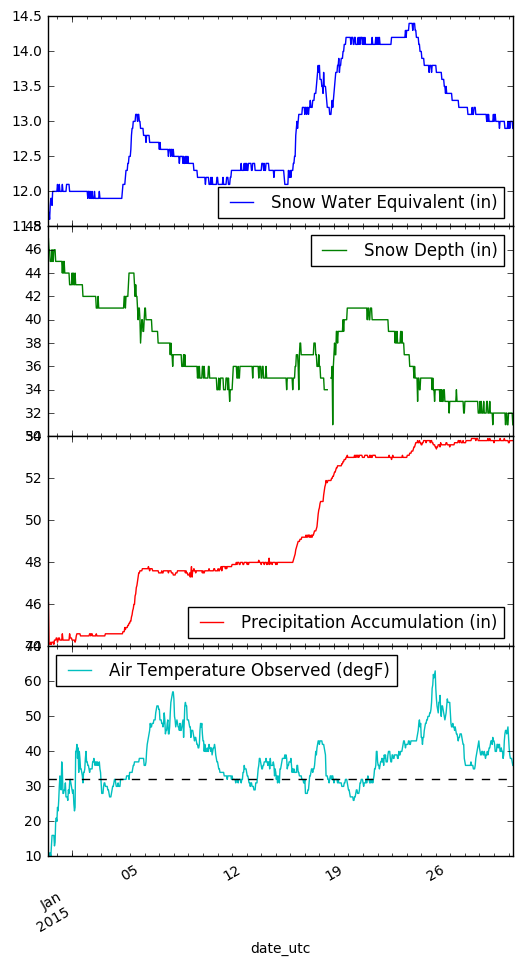

In [8]:
axes = df.plot(subplots=True, figsize=(6,12), legend=True)
plt.subplots_adjust(hspace=0)
axes[-1].axhline(32, c='k', ls='--')

# NWAC ratings comparison

for mt Hood

In [9]:
import sqlalchemy as sa

In [10]:
engine = sa.create_engine('postgres://%s@localhost/%s'%('tkb','avy'))
print(engine.url)

postgres://tkb@localhost/avy


In [11]:
metadata = sa.MetaData()

report_table = sa.Table('reports', metadata,
                        sa.Column('report_id', sa.Integer,
                                  primary_key=True, autoincrement=False),
                          sa.Column('datetime', sa.Text),
                          sa.Column('datetime_utc', sa.DateTime),
                          sa.Column('author', sa.Text),
                          sa.Column('region', sa.Text),
                          sa.Column('summary', sa.Text),
                          sa.Column('treeline_above', sa.Text),
                          sa.Column('treeline_near', sa.Text),
                          sa.Column('treeline_below', sa.Text),
                        )

In [12]:
def fetch_nwac_ratings(range_min, range_max):
    stmt = sa.select([report_table]
                    ).where(
                        report_table.c.region == 'Mt Hood'
                    ).where(
                        report_table.c.datetime_utc <= range_max
                    ).where(
                        report_table.c.datetime_utc >= range_min
                    ).order_by(report_table.c.datetime_utc)

    df2 = pd.read_sql_query(stmt, engine)
    df2 = df2.set_index('datetime_utc')
    return df2

In [13]:
df2 = fetch_nwac_ratings(range_min, range_max)
df2.head()

,report_id,datetime,author,region,summary,treeline_above,treeline_near,treeline_below
datetime_utc,,,,,,,,
2014-12-31 02:23:00,988,"6:23 PM PST Tuesday, December 30, 2014",Kenny Kramer,Mt Hood,As the weekend storm slabs become less of a pr...,Considerable,Moderate,Moderate
2015-01-01 02:00:00,994,"6:00 PM PST Wednesday, December 31, 2014",Kenny Kramer,Mt Hood,Recent N-NE winds have created some wind slab ...,Moderate,Moderate,Moderate
2015-01-02 02:00:00,998,"6:00 PM PST Thursday, January 1, 2015",Garth Ferber,Mt Hood,Watch for lingering wind slab from early in th...,Moderate,Moderate,Moderate
2015-01-03 02:00:00,1002,"6:00 PM PST Friday, January 2, 2015",Garth Ferber,Mt Hood,Watch mainly for lingering local wind slab fro...,Moderate,Moderate,Moderate
2015-01-04 01:52:00,1006,"5:52 PM PST Saturday, January 3, 2015",Dennis D'Amico,Mt Hood,The avalanche danger will increase sharply by ...,Considerable,Considerable,Considerable


In [14]:
ratings = ['No Rating', 'Low', 'Moderate', 'Considerable', 'High', 'Extreme']

In [15]:
# convert to a numerical rating
ratdict = {rat:i for i,rat in enumerate(ratings)}

ratings_to_numbers = {'treeline_above':ratdict,
            'treeline_below':ratdict,
            'treeline_near':ratdict,}

df2.replace(ratings_to_numbers).head()

,report_id,datetime,author,region,summary,treeline_above,treeline_near,treeline_below
datetime_utc,,,,,,,,
2014-12-31 02:23:00,988,"6:23 PM PST Tuesday, December 30, 2014",Kenny Kramer,Mt Hood,As the weekend storm slabs become less of a pr...,3,2,2
2015-01-01 02:00:00,994,"6:00 PM PST Wednesday, December 31, 2014",Kenny Kramer,Mt Hood,Recent N-NE winds have created some wind slab ...,2,2,2
2015-01-02 02:00:00,998,"6:00 PM PST Thursday, January 1, 2015",Garth Ferber,Mt Hood,Watch for lingering wind slab from early in th...,2,2,2
2015-01-03 02:00:00,1002,"6:00 PM PST Friday, January 2, 2015",Garth Ferber,Mt Hood,Watch mainly for lingering local wind slab fro...,2,2,2
2015-01-04 01:52:00,1006,"5:52 PM PST Saturday, January 3, 2015",Dennis D'Amico,Mt Hood,The avalanche danger will increase sharply by ...,3,3,3


In [16]:
series = df2.replace(ratings_to_numbers)['treeline_above'].resample('1H', fill_method='pad')
series.name = 'NWAC Warning level'
dfx = df.join(series, how='inner')

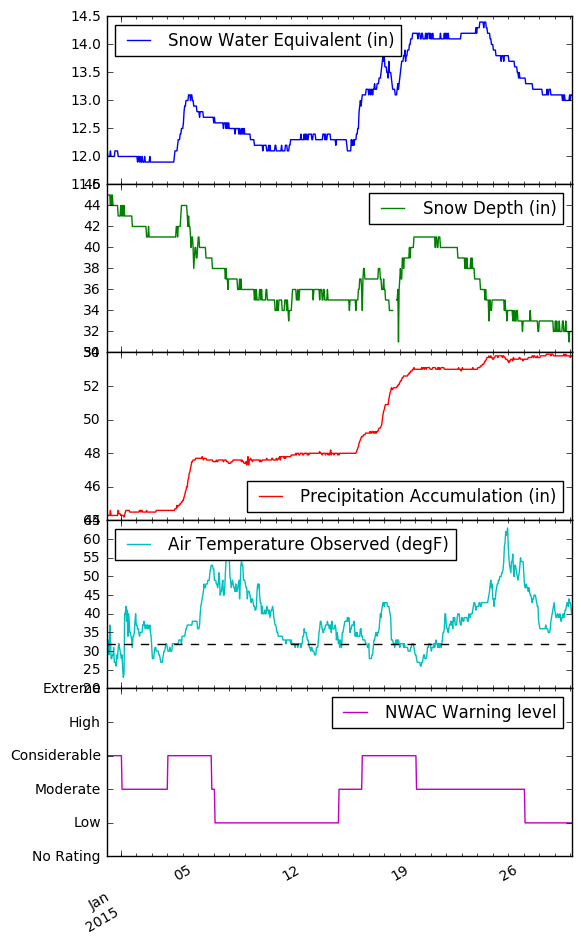

In [17]:
axes = dfx.plot(subplots=True, figsize=(6,12), legend=True)
plt.subplots_adjust(hspace=0)

axes[-2].axhline(32, c='k', ls='--')
axes[-1].set_ylim(-0,5);
axes[-1].set_yticklabels(ratings)
#axes[-1].lines[0].set_marker('o')

#plt.savefig('jan2015.pdf')

# closer look at downgrade on Jan 7

In [18]:
import datetime
roi_begin = datetime.datetime(2015,1,6, 12)
roi_end = datetime.datetime(2015,1,8, 12)

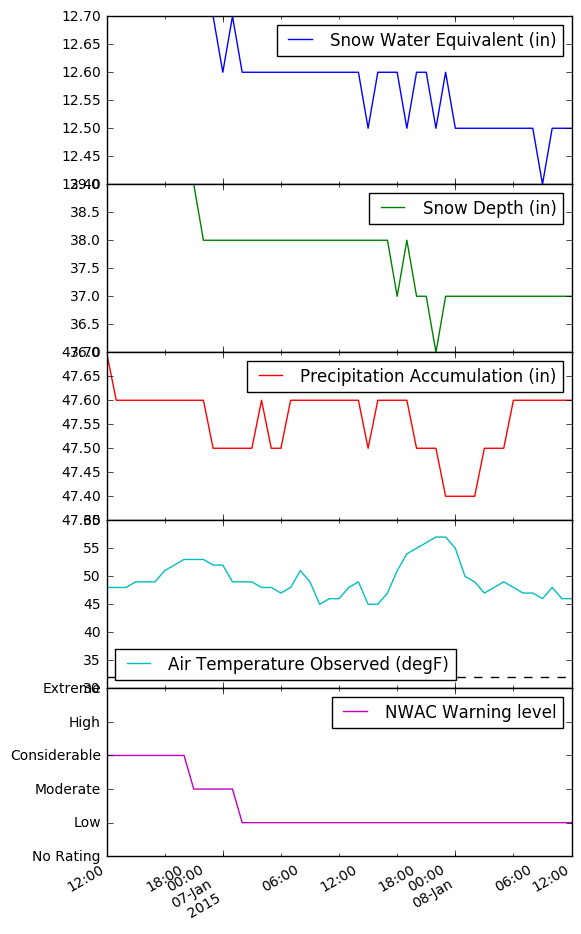

In [19]:
axes = dfx.ix[roi_begin:roi_end].plot(subplots=True, figsize=(6,12), legend=True)
plt.subplots_adjust(hspace=0)

axes[-2].axhline(32, c='k', ls='--')
axes[-1].set_ylim(-0,5);
axes[-1].set_yticklabels(ratings)

downgrade happened at 2100, aka 1300. 1pm.

In [20]:
df2.ix[roi_begin:roi_end]

,report_id,datetime,author,region,summary,treeline_above,treeline_near,treeline_below
datetime_utc,,,,,,,,
2015-01-06 21:28:00,1014,"1:28 PM PST Tuesday, January 6, 2015",Kenny Kramer,Mt Hood,"Areas of wet snow are expected, especially on ...",Moderate,Moderate,Moderate
2015-01-07 02:00:00,1019,"6:00 PM PST Tuesday, January 6, 2015",Kenny Kramer,Mt Hood,"Triggered avalanches are unlikely, but areas o...",Low,Low,Low
2015-01-07 20:12:00,1023,"12:12 PM PST Wednesday, January 7, 2015",Garth Ferber,Mt Hood,"Triggered avalanches are unlikely, but areas o...",Low,Low,Low
2015-01-08 02:00:00,1027,"6:00 PM PST Wednesday, January 7, 2015",Garth Ferber,Mt Hood,Avoid steep sun exposed slopes if snow becomes...,Low,Low,Low


# Daily binning

feature engineering: make this into scatter plots

In [22]:
def make_engineered_features(usda_df, nwac_usda_df):
    
    features = {
        'treeline_above': nwac_usda_df.replace(ratings_to_numbers)['treeline_above'].resample('1D', how='last'),
        'precip_today': usda_df['Precipitation Accumulation (in)'].resample('1D').diff(),
        'snowdep':      usda_df['Snow Depth (in)'].resample('1D'),
        'watereq':      usda_df['Snow Water Equivalent (in)'].resample('1D'),
        'avgtemp':      usda_df['Air Temperature Observed (degF)'].resample('1D'),
    }
    
    features['tempchange'] = features['avgtemp'].diff()
    # pseudo-density: don't divide by zero
    features['density'] = features['watereq'] / (features['snowdep'] + 1)

    engineered = pd.DataFrame(features)

    return engineered


In [23]:
def data_for_range(range_min, range_max):
    dfa = get_usda_data(651, range_min,range_max)
    dfb = fetch_nwac_ratings(range_min, range_max)
    return make_engineered_features(dfa, dfb)

2014-12-30 2015-01-30


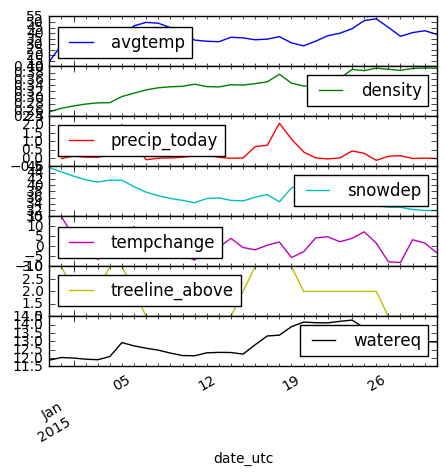

In [24]:
engineered = data_for_range(range_min, range_max)

engineered.plot(subplots=True)
plt.subplots_adjust(hspace=0)

In [25]:
engineered.columns

Index(['avgtemp', 'density', 'precip_today', 'snowdep', 'tempchange',
       'treeline_above', 'watereq'],
      dtype='object')

In [26]:
ratings = ['No Rating', 'Low', 'Moderate', 'Considerable', 'High', 'Extreme']
colors = ['gray', 'green', 'yellow', 'orange', 'red', 'black']
coldict = {rating:color for rating, color in zip(ratings, colors)}

numdict = {i:color for i, color in enumerate(colors)}
labdict = {i:rating for i, rating in enumerate(ratings)}
coldict

{'Considerable': 'orange',
 'Extreme': 'black',
 'High': 'red',
 'Low': 'green',
 'Moderate': 'yellow',
 'No Rating': 'gray'}

In [27]:
def plot_classes(engineered, x, y, ax=None):
    if ax is None:
        ax = plt.gca()
    for val,subdf in engineered.groupby('treeline_above'):
        subdf.plot(kind='scatter',
                    x=x, y=y,
                    c=numdict.get(val, 'm'),
                    label=labdict.get(val, val),
                    ax=ax)
    ax.legend(loc='upper left', ncol=2)
 

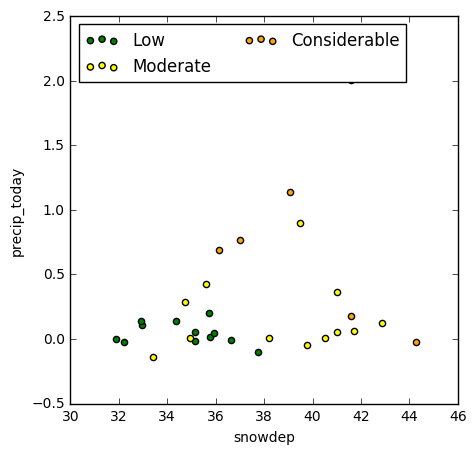

In [28]:
plot_classes(engineered,
             x='snowdep', y='precip_today')

# much more data

In [29]:
engineered2 = data_for_range(pd.datetime(2013,11,1),
                            pd.datetime(2015,5,1))

2013-10-31 2015-04-30


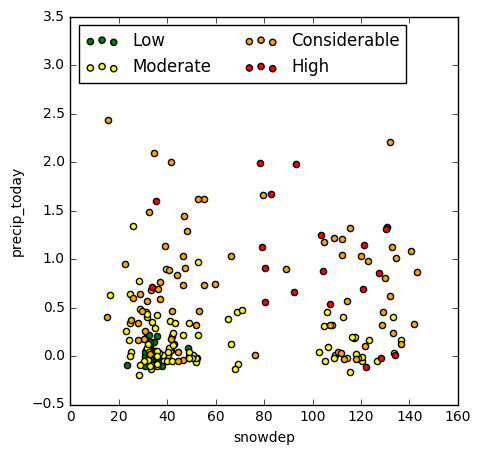

In [30]:
plot_classes(engineered2, x='snowdep', y='precip_today')

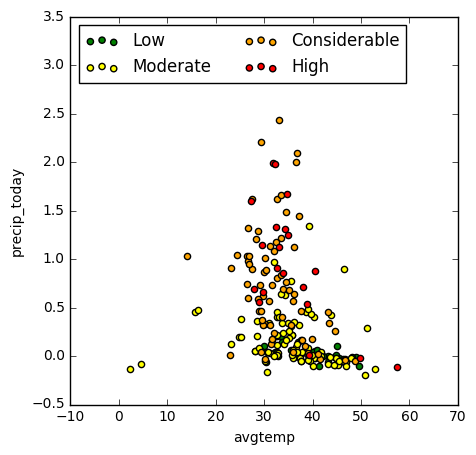

In [31]:
plot_classes(engineered2, x='avgtemp', y='precip_today')

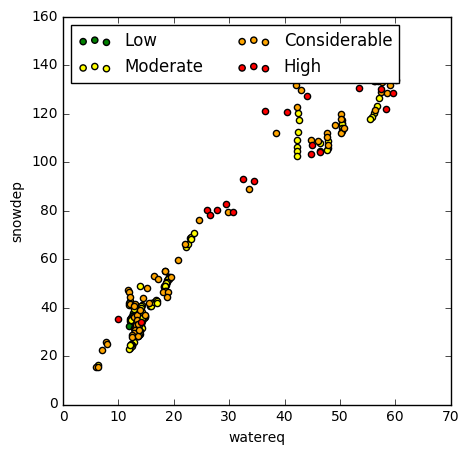

In [32]:
plot_classes(engineered2, y='snowdep', x='watereq')

binning by the day is probably a bad approach. for each avalanche report, we should construct a time window extending 24 hours (or whatever) back in time from the date the report was issued. This would avoid sampling future data, and also avoid 2 reports on the same day getting their numerical values averaged

TODO!

# fit some models!

In [33]:
from sklearn import svm
from sklearn import metrics

In [41]:
def split_set(training_set):
    label = 'treeline_above'
    predictors = ['avgtemp', 'density', 'precip_today', 'snowdep', 'tempchange', 'watereq']

    mask = training_set[predictors + [label,]].isnull().any(axis=1)

    train = training_set[predictors]
    target = training_set[label]
    
    train_masked = train[~mask].values
    target_masked = target[~mask].values
    
    return train_masked, target_masked

def train_model(model, training_set):
    train_masked, target_masked = split_set(training_set)
    
    # this returns itself
    model = model.fit(train_masked, target_masked)
    
    result = model.predict(train_masked)
    training_score = metrics.accuracy_score(target_masked, result)
    
    return model, training_score

In [42]:
from sklearn.linear_model import LogisticRegression
model, score = train_model(LogisticRegression(C = 1e3, penalty='l2'), engineered2)
score

0.63849765258215962

In [48]:
from sklearn.svm import SVC
model, score = train_model(SVC(C = 1e3, kernel='linear'), engineered2)
score

0.68544600938967137

# validation data

In [43]:
validation = data_for_range(pd.datetime(2015,11,1),
                            pd.datetime(2016,2,1))

2015-10-31 2016-01-31


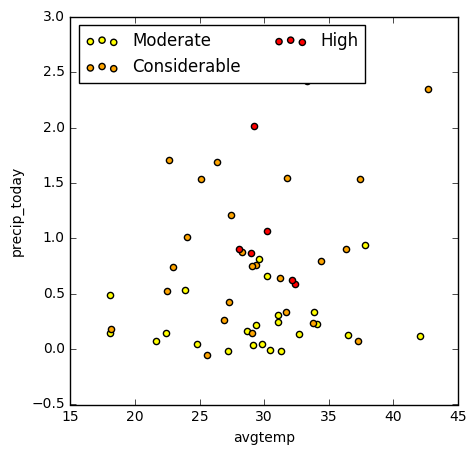

In [44]:
plot_classes(validation, x='avgtemp', y='precip_today')

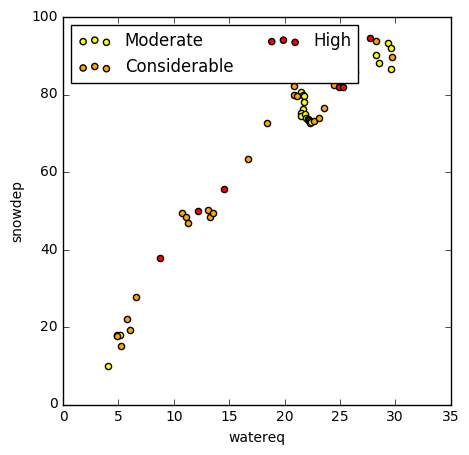

In [45]:
plot_classes(validation, y='snowdep', x='watereq')

In [47]:
valid_masked, target_masked = split_set(validation)

result = model.predict(valid_masked)
score = metrics.accuracy_score(target_masked, result)

score

0.62962962962962965

In [49]:
valid_masked, target_masked = split_set(validation)

result = model.predict(valid_masked)
score = metrics.accuracy_score(target_masked, result)

score

0.61111111111111116

both scores dropped; I think this means that we need more dimensions to the data (not more advanced models)

# slow models

In [ ]:
from sklearn.svm import SVC
model, score = train_model(SVC(C = 1e6, kernel='poly'), engineered2)
score

In [ ]:
from sklearn.svm import SVC
model, score = train_model(SVC(C = 1e6, kernel='rbf'), engineered2)
score

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model, score = train_model(RandomForestClassifier(), engineered2)
score

# Ad hoc testing

In [166]:
model.predict([[30, .4, 0, 34, 0, 13], # no precip today
               [30, .4, 1, 34, 0, 13], # 1in precip today
              ])

array([ 1.,  3.])

seems reasonable.

In [167]:
from sklearn.externals import joblib
joblib.dump(model, 'filename.pkl') 

['filename.pkl',
 'filename.pkl_01.npy',
 'filename.pkl_02.npy',
 'filename.pkl_03.npy',
 'filename.pkl_04.npy']

# To do

- re-do this to select 24 hour window prior to each report
- routine which just grabs 24 hours prior to any given time
- validate model on some other set of data
- write a flask app